<a href="https://colab.research.google.com/github/rnayebi21/PolygenceMLResearch-scRNAseq/blob/main/Gene_Expression_Stem_cells_Models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#First get the imports ready

In [3]:
!pip install pingouin

     |████████████████████████████████| 225kB 12.6MB/s 
  Created wheel for pingouin: filename=pingouin-0.3.8-cp36-none-any.whl size=221687 sha256=41ca8e0f83e3564901bd8c8dec2f331955e9ed4720af79808065b64d41f574a1
  Stored in directory: /root/.cache/pip/wheels/d6/9e/53/f885f73f29cf7c8cac3d8f4b1532bbfef2f5eb543946ac9055
  Created wheel for outdated: filename=outdated-0.2.0-cp36-none-any.whl size=4961 sha256=78a5bf98956709440946cefa0362a87ae9667acb5e213b19f1762ea5dd78d76c
  Stored in directory: /root/.cache/pip/wheels/fd/7c/ef/814f514d31197310872b5abf353feb8fef9d67ee658e1e7e39
  Created wheel for littleutils: filename=littleutils-0.2.2-cp36-none-any.whl size=7051 sha256=8c4392c723efc559c06c601bcc520dad003a8b8b4287808ca491ec2b0ef60cdf
  Stored in directory: /root/.cache/pip/wheels/53/16/9f/ac67d15c40243754fd73f620e1b9b6dedc20492ecc19a2bae1
Successfully built pingouin outdated littleutils


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tqdm
import seaborn as sns
import pingouin as pg
from collections import Counter

from sklearn import metrics
from sklearn import model_selection, linear_model
from sklearn import decomposition
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.naive_bayes import GaussianNB
from sklearn import svm
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier 


from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

sns.set()

Next we must log into google drive to access the files

In [2]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

Gathering the metadata from google drive via the IDs of each google file

In [3]:
Intestinal_Stem_Cell_Metadata_ID = "1R_tDWJ1nyzwQSANTxc33AkhzxdSyVlyB"
Stem_file = drive.CreateFile({'id':Intestinal_Stem_Cell_Metadata_ID})
Stem_file.GetContentFile('MHCII_Paper_All_Metadata.txt')
Stem_metadata = pd.read_csv("MHCII_Paper_All_Metadata.txt", sep = "\t")


Stem_gene_expression_ID = "1p0_onfldu42vfTXvehCgXQz5p9OP7I6n"
Stem_GE_file = drive.CreateFile({'id':Stem_gene_expression_ID})
Stem_GE_file.GetContentFile('FigS4D_Log2TPM.txt')
Stem_GE = pd.read_csv("FigS4D_Log2TPM.txt", sep = "\t")

For later we will also want to have the gene expression data

Check If Dimensions between metadata and expession data are the same

In [ ]:
print("meta dims: " + str(np.shape(Stem_metadata)) + "\ngene expression dims: " + str(np.shape(Stem_GE)))

meta dims: (28463, 7)
gene expression dims: (27998, 3177)


There is an extra column that is just a numbering the columns so we will replace this with Name of the cell instead

In [4]:
Stem_metadata.index = Stem_metadata.NAME
Stem_metadata = Stem_metadata.drop("NAME", axis = 1)

Let's take a look at the data:

In [ ]:
Stem_metadata

,Mouse,Cluster,nGene,Cell-cycle,Condition,Genotype
NAME,,,,,,
TYPE,group,group,numeric,numeric,group,group
SI_2_WT_ISC-II,M1,ISC-II,6621,-0.736310913207205,Homeostasis,WT
SI_3_WT_ISC-III,M1,ISC-III,6924,0.697446527862526,Homeostasis,WT
SI_11_WT_ISC-III,M1,ISC-III,5258,2.60214979713636,Homeostasis,WT
SI_12_WT_ISC-III,M1,ISC-III,7030,1.33324450423009,Homeostasis,WT
...,...,...,...,...,...,...
TTTGTCAAGTTGAGTA_CD45_MHCIIGut--_M3_Homeostasis_B cell,CTL_KO_6,B cell,1610,-0.0840489500363403,Homeostasis,MHCIIGut-/-
TTTGTCACACGAAAGC_CD45_MHCIIGut--_M3_Homeostasis_CD4,CTL_KO_6,CD4,2164,-0.0214414256719445,Homeostasis,MHCIIGut-/-
TTTGTCATCCGTACAA_CD45_MHCIIGut--_M3_Homeostasis_CD4,CTL_KO_6,CD4,1262,-0.11279579553117,Homeostasis,MHCIIGut-/-


In [ ]:
Stem_GE

,GENE,AAATCAACGAATGA_MHCII_Flox_Control_1_Enterocyte.prog,AAATCATGTGCCTC_MHCII_Flox_Control_1_Enterocyte.prog,AAATCCCTCCTTAT_MHCII_Flox_Control_1_Stem,AACCGCCTCGCTAA_MHCII_Flox_Control_1_Enterocyte,AACGTCGATAACCG_MHCII_Flox_Control_1_Enterocyte.prog,AAGAACGAAGAATG_MHCII_Flox_Control_1_Enterocyte.prog,AAGATGGATTCAGG_MHCII_Flox_Control_1_Enterocyte.prog,AAGCCTGACTTCGC_MHCII_Flox_Control_1_Enterocyte.prog,AAGGCTTGATTCCT_MHCII_Flox_Control_1_Stem,AAGTAGGACAAGCT_MHCII_Flox_Control_1_TA,AAGTGCACGCGTTA_MHCII_Flox_Control_1_Enterocyte.prog,AATCGGTGGTGCTA_MHCII_Flox_Control_1_Stem,AATGGCTGGGTATC_MHCII_Flox_Control_1_Goblet,ACAAATTGCAGAAA_MHCII_Flox_Control_1_Endocrine,ACAGACACTATGGC_MHCII_Flox_Control_1_Goblet,ACCACCTGTTCCGC_MHCII_Flox_Control_1_TA,ACCAGTGATGCCCT_MHCII_Flox_Control_1_TA,ACCCAAGAGACTAC_MHCII_Flox_Control_1_Stem,ACCCGTACCTTTAC_MHCII_Flox_Control_1_Enterocyte.prog,ACCGAAACATAAGG_MHCII_Flox_Control_1_Enterocyte.prog,ACGGCTCTGCTACA_MHCII_Flox_Control_1_Stem,ACTCTATGATGGTC_MHCII_Flox_Control_1_Goblet,ACTCTATGTCTACT_MHCII_Flox_Control_1_Stem,ACTTCTGACCGAAT_MHCII_Flox_Control_1_Stem,AGAGTCACGGTGAG_MHCII_Flox_Control_1_Stem,AGCCTCACTTCCCG_MHCII_Flox_Control_1_TA,AGCTGCCTAATGCC_MHCII_Flox_Control_1_TA,AGGCAGGAGGAAGC_MHCII_Flox_Control_1_Enterocyte.prog,AGGGCCACCTCCCA_MHCII_Flox_Control_1_Stem,AGTAATACTCTAGG_MHCII_Flox_Control_1_Stem,AGTCAGACGAATCC_MHCII_Flox_Control_1_Enterocyte.prog,AGTCCAGATTCGCC_MHCII_Flox_Control_1_Enterocyte.prog,AGTCGCCTTGTTTC_MHCII_Flox_Control_1_Enterocyte.prog,AGTCTACTGCTGAT_MHCII_Flox_Control_1_TA,AGTGTGACCCCGTT_MHCII_Flox_Control_1_Enterocyte,AGTTATGAAACGGG_MHCII_Flox_Control_1_Enterocyte.prog,AGTTCTACTCGCCT_MHCII_Flox_Control_1_Stem,ATACCTTGCTCATT_MHCII_Flox_Control_1_TA,ATACTCTGACGACT_MHCII_Flox_Control_1_Stem,...,TGCTGCTTCGCTTGTC_MHCII_dGut_5_TA,TGGCCAGAGCGTAATA_MHCII_dGut_5_Goblet,TGGCTGGGTTATGCGT_MHCII_dGut_5_Enterocyte.prog,TGGGAAGAGACACGAC_MHCII_dGut_5_Enterocyte.prog,TGGGAAGAGGTGCTAG_MHCII_dGut_5_TA,TGGGAAGCACAGCGTC_MHCII_dGut_5_Stem,TGGGCGTAGGTGCACA_MHCII_dGut_5_Enterocyte.prog,TGGTTAGAGCGATCCC_MHCII_dGut_5_TA,TGGTTAGCAGCCTGTG_MHCII_dGut_5_Tuft,TGGTTCCCACGAAACG_MHCII_dGut_5_TA,TGGTTCCCAGTGGGAT_MHCII_dGut_5_Stem,TGGTTCCGTACAGCAG_MHCII_dGut_5_TA,TGTATTCGTTCCATGA_MHCII_dGut_5_Enterocyte.prog,TGTGTTTTCTAACTTC_MHCII_dGut_5_TA,TGTGTTTTCTTCAACT_MHCII_dGut_5_TA,TGTTCCGAGAAGGGTA_MHCII_dGut_5_Stem,TGTTCCGAGCCCTAAT_MHCII_dGut_5_Enterocyte.prog,TGTTCCGTCCGCAGTG_MHCII_dGut_5_Stem,TTAACTCAGCGACGTA_MHCII_dGut_5_TA,TTAGGCACACCAGGCT_MHCII_dGut_5_TA,TTAGTTCAGCTAGCCC_MHCII_dGut_5_Stem,TTAGTTCGTAAGTAGT_MHCII_dGut_5_Stem,TTCGGTCAGACACTAA_MHCII_dGut_5_Enterocyte.prog,TTCGGTCGTAAAGTCA_MHCII_dGut_5_Paneth,TTCTACATCGTGGTCG_MHCII_dGut_5_Enterocyte.prog,TTCTCCTCATCGGGTC_MHCII_dGut_5_Enterocyte.prog,TTCTTAGTCAATAAGG_MHCII_dGut_5_Enterocyte.prog,TTCTTAGTCAGGTTCA_MHCII_dGut_5_Endocrine,TTGAACGAGATCTGCT_MHCII_dGut_5_Enterocyte.prog,TTGAACGCACTAAGTC_MHCII_dGut_5_TA,TTGCCGTGTTGTACAC_MHCII_dGut_5_Stem,TTGCGTCAGTCATGCT_MHCII_dGut_5_Enterocyte,TTGTAGGAGAAACCGC_MHCII_dGut_5_Stem,TTGTAGGGTAATTGGA_MHCII_dGut_5_Enterocyte.prog,TTGTAGGGTACTCGCG_MHCII_dGut_5_Stem,TTTACTGCAACTTGAC_MHCII_dGut_5_TA,TTTACTGGTCTCAACA_MHCII_dGut_5_Tuft,TTTACTGTCGAACTGT_MHCII_dGut_5_Enterocyte.prog,TTTATGCTCCACGAAT_MHCII_dGut_5_Stem,TTTCCTCGTCGCTTTC_MHCII_dGut_5_TA
0,Xkr4,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.0000
1,Gm1992,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0

In [5]:
Stem_GE = Stem_GE.transpose()

In [ ]:
Stem_GE.index

Index(['GENE', 'AAATCAACGAATGA_MHCII_Flox_Control_1_Enterocyte.prog',
       'AAATCATGTGCCTC_MHCII_Flox_Control_1_Enterocyte.prog',
       'AAATCCCTCCTTAT_MHCII_Flox_Control_1_Stem',
       'AACCGCCTCGCTAA_MHCII_Flox_Control_1_Enterocyte',
       'AACGTCGATAACCG_MHCII_Flox_Control_1_Enterocyte.prog',
       'AAGAACGAAGAATG_MHCII_Flox_Control_1_Enterocyte.prog',
       'AAGATGGATTCAGG_MHCII_Flox_Control_1_Enterocyte.prog',
       'AAGCCTGACTTCGC_MHCII_Flox_Control_1_Enterocyte.prog',
       'AAGGCTTGATTCCT_MHCII_Flox_Control_1_Stem',
       ...
       'TTGCCGTGTTGTACAC_MHCII_dGut_5_Stem',
       'TTGCGTCAGTCATGCT_MHCII_dGut_5_Enterocyte',
       'TTGTAGGAGAAACCGC_MHCII_dGut_5_Stem',
       'TTGTAGGGTAATTGGA_MHCII_dGut_5_Enterocyte.prog',
       'TTGTAGGGTACTCGCG_MHCII_dGut_5_Stem',
       'TTTACTGCAACTTGAC_MHCII_dGut_5_TA',
       'TTTACTGGTCTCAACA_MHCII_dGut_5_Tuft',
       'TTTACTGTCGAACTGT_MHCII_dGut_5_Enterocyte.prog',
       'TTTATGCTCCACGAAT_MHCII_dGut_5_Stem',
       'TTTCCTCGTCG

In [ ]:
Stem_metadata.index

Index(['TYPE', 'SI_2_WT_ISC-II', 'SI_3_WT_ISC-III', 'SI_11_WT_ISC-III',
       'SI_12_WT_ISC-III', 'SI_15_WT_ISC-III', 'SI_17_WT_ISC-II',
       'SI_19_WT_ISC-II', 'SI_20_WT_ISC-II', 'SI_21_WT_ISC-III',
       ...
       'TTTGGTTGTTACGCGC_CD45_MHCIIGut--_M3_Homeostasis_B cell',
       'TTTGGTTTCACTTCAT_CD45_MHCIIGut--_M3_Homeostasis_Monocyte (cycling)',
       'TTTGGTTTCCCAAGTA_CD45_MHCIIGut--_M3_Homeostasis_B cell',
       'TTTGGTTTCCGTACAA_CD45_MHCIIGut--_M3_Homeostasis_CD4',
       'TTTGTCAAGCTAGTCT_CD45_MHCIIGut--_M3_Homeostasis_Monocyte (cycling)',
       'TTTGTCAAGTTGAGTA_CD45_MHCIIGut--_M3_Homeostasis_B cell',
       'TTTGTCACACGAAAGC_CD45_MHCIIGut--_M3_Homeostasis_CD4',
       'TTTGTCATCCGTACAA_CD45_MHCIIGut--_M3_Homeostasis_CD4',
       'TTTGTCATCGGAAACG_CD45_MHCIIGut--_M3_Homeostasis_B cell',
       'TTTGTCATCGTCCGTT_CD45_MHCIIGut--_M3_Homeostasis_B cell'],
      dtype='object', name='NAME', length=28463)

In [6]:
common_cells = []
for i in range(len(Stem_metadata.index)):
  if Stem_metadata.index[i] in Stem_GE.index:
    common_cells.append(Stem_metadata.index[i])

In [ ]:
len(common_cells)

3176

In [7]:
Stem_metadata_copy = Stem_metadata 
for i in range(len(Stem_metadata_copy.index)):
  if Stem_metadata_copy.index[i] not in common_cells:
    Stem_metadata = Stem_metadata.drop(Stem_metadata_copy.index[i], axis = 0)
    if i == int(len(Stem_metadata_copy.index)/2):
      print("halfway done!")

halfway done!


In [8]:
Stem_metadata.index.name = ""

In [9]:
Stem_GE.columns = Stem_GE.loc["GENE"]
Stem_GE = Stem_GE.drop("GENE", axis = 0)

In [ ]:
list_of_types = []
for i in range(len(Stem_metadata["Cluster"])):
  if (Stem_metadata["Cluster"])[i] not in list_of_types:
    list_of_types.append((Stem_metadata["Cluster"])[i])
print("len", len(list_of_types))
list_of_types

len 8


['Goblet',
 'Enteroendocrine',
 'Stem',
 'Paneth',
 'Enterocyte',
 'Enterocyte.prog',
 'TA',
 'Tuft']

In [ ]:
list_of_types_total = []
for i in range(len(Stem_metadata_copy["Cluster"])):
  if (Stem_metadata_copy["Cluster"])[i] not in list_of_types_total:
    list_of_types_total.append((Stem_metadata_copy["Cluster"])[i])
list_of_types_total    

['group',
 'ISC-II',
 'ISC-III',
 'ISC-I',
 'Goblet',
 'Enteroendocrine',
 'Stem',
 'Paneth',
 'Enterocyte',
 'Enterocyte.prog',
 'TA',
 'Tuft',
 'Macrophage (M2)',
 'CD8',
 'DC',
 'Epithelial',
 'Plasma cell',
 'Inflammatory Monocytes',
 'Monocyte (cycling)',
 'Neutrophil',
 'CD4',
 'NK',
 'B cell',
 'pDC']

In [10]:
labels = Stem_metadata["Cluster"]

We can see that we actually shouldn't use standard deviation as the data is not normally distrbuted 

In [ ]:
pg.normality(Stem_GE)

ValueError: ignored

In [ ]:
v = Stem_GE.cumsum()
v.plot()

ValueError: ignored

<Figure size 432x288 with 1 Axes>

#PCA visualization (using 2 principal components)

Let's visualize what we have so far using PCA

In [ ]:
pca = PCA(n_components=2)

#reducing the gene expression data
principalComponents_Stem_GE = pca.fit_transform(Stem_GE)
principalDf_Stem_GE = pd.DataFrame(data = principalComponents_Stem_GE, columns = ['principal component 1', 'principal component 2'])



In [ ]:
labels_df = pd.DataFrame(labels)

In [ ]:
principalDf_Stem_GE.index = labels_df.index

In [ ]:
finalDf = pd.concat([principalDf_Stem_GE, labels_df], axis=1, sort=False)

In [ ]:
finalDf

,principal component 1,principal component 2,Cluster
,,,
AAATCAACGAATGA_MHCII_Flox_Control_1_Enterocyte.prog,3.870051,17.163065,Goblet
AAATCATGTGCCTC_MHCII_Flox_Control_1_Enterocyte.prog,2.010592,18.810437,Enteroendocrine
AAATCCCTCCTTAT_MHCII_Flox_Control_1_Stem,-0.125172,19.871726,Stem
AACCGCCTCGCTAA_MHCII_Flox_Control_1_Enterocyte,4.247249,15.782414,Enteroendocrine
AACGTCGATAACCG_MHCII_Flox_Control_1_Enterocyte.prog,0.962840,20.369665,Stem
...,...,...,...
TTTACTGCAACTTGAC_MHCII_dGut_5_TA,-12.819165,-1.342161,Stem
TTTACTGGTCTCAACA_MHCII_dGut_5_Tuft,12.929128,-3.643834,Paneth
TTTACTGTCGAACTGT_MHCII_dGut_5_Enterocyte.prog,-14.937483,-1.460993,Stem


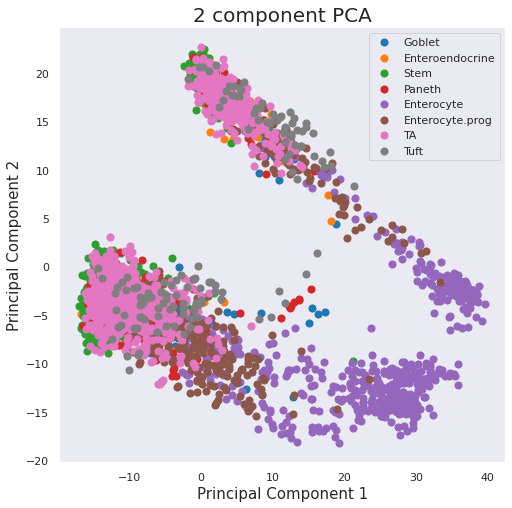

In [ ]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)
targets = ['Goblet','Enteroendocrine','Stem','Paneth','Enterocyte','Enterocyte.prog','TA','Tuft']
# colors = ['r', 'g', 'b']
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f'] # '#bcbd22', '#17becf', '#cbf72d']
for target, color in zip(targets,colors):
    indicesToKeep = finalDf["Cluster"] == target
    ax.scatter(finalDf.loc[indicesToKeep, 'principal component 1']
               , finalDf.loc[indicesToKeep, 'principal component 2']
               , c = color
               , s = 50)
ax.legend(targets)
ax.grid()


As we can see, this data may be a little harder to predict with

In [31]:
def confusion_matrix_Stem (lbl, pred):
  cm = metrics.confusion_matrix(lbl, pred)
  plt.figure(figsize=(11,11))
  plt.imshow(cm, interpolation='nearest', cmap='Pastel1')
  plt.title('Confusion Matrix', size = 15)
  plt.colorbar()
  tick_marks = np.arange(8)
  plt.xticks(tick_marks, ['Goblet','Enteroendocrine','Stem','Paneth','Enterocyte','Enterocyte.prog','TA','Tuft'], rotation = 45, size = 10)
  plt.yticks(tick_marks, ['Goblet','Enteroendocrine','Stem','Paneth','Enterocyte','Enterocyte.prog','TA','Tuft'], size = 10)
  plt.tight_layout()
  plt.ylabel('Actual', size = 15)
  plt.xlabel('Predicted', size = 15)
  width, height = cm.shape

  for x in range(width):
    for y in range(height):
      plt.annotate(str(cm[x][y]), xy=(y, x), horizontalalignment='center', verticalalignment='center')

Now we will look at each model specifically and see what parametrs work the best for them

# PCA for dimensionality reduction

In [12]:
x_train,x_test,train_lbls,test_lbls=train_test_split(Stem_GE,labels,test_size=0.3,random_state=0)

trying to see how much information we should retain using PCA

In [13]:
num_components = np.array([])
for i in range(1, 11):
  delta = (i/2)/10
  pca = PCA(1 - delta)
  pca.fit(x_train)
  num_components = np.append(pca.n_components_, num_components)
  print(*[i, ":", pca.n_components_])

1 : 1651
2 : 1335
3 : 1106
4 : 924
5 : 773
6 : 644
7 : 531
8 : 432
9 : 344
10 : 265


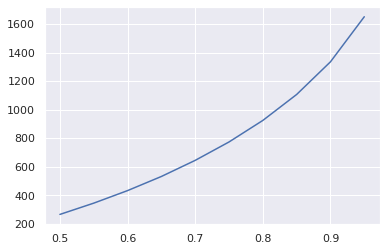

In [15]:
index_of_PCA =  [0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95]
plt.plot(index_of_PCA, num_components)

not much of an elbow in the graph but we will just use 0.8

In [16]:
pca = PCA(0.8)
pca.fit(Stem_GE)
Stem_GE_PCA = pca.transform(Stem_GE)

now that we have this we will save everything we have done so we don't have to do it again in the future, and instead can just reference the files

In [17]:
pd.DataFrame(Stem_GE_PCA).to_csv("Stem_GE_PCA.csv")
pd.DataFrame(labels).to_csv("Stem_labels.csv")

#Preprocessing for Standard Scaler + PCA (for GNB)


(Run this separate from the previous PCA code) Now we will do the same code except we will use standard scaling (despite the data already being log normalized). Our Gaussian Naive Bayes classifier did not work very well and we will do this to try and see if this would change the accuracy of the mdoel.

In [11]:
scaler = StandardScaler()
scaler.fit(Stem_GE, labels)
Stem_GE_scaled = scaler.transform(Stem_GE)

In [12]:
x_train,x_test,train_lbls,test_lbls=train_test_split(Stem_GE_scaled,labels,test_size=0.3,random_state=0)

In [13]:
num_components = np.array([])
for i in range(1, 11):
  delta = (i/2)/10
  pca = PCA(1 - delta)
  pca.fit(x_train)
  num_components = np.append(pca.n_components_, num_components)
  print(*[i, ":", pca.n_components_])

1 : 1892
2 : 1658
3 : 1465
4 : 1297
5 : 1147
6 : 1011
7 : 887
8 : 773
9 : 668
10 : 570


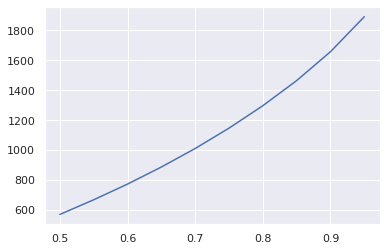

In [14]:
index_of_PCA =  [0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95]
plt.plot(index_of_PCA, num_components)

In [15]:
pca = PCA(0.8)
pca.fit(Stem_GE_scaled)
Stem_GE_scaled_PCA = pca.transform(Stem_GE_scaled)

In [16]:
pd.DataFrame(Stem_GE_scaled_PCA).to_csv("Stem_GE_scaled_PCA.csv")

#Downloading Pre-processed Files we Created with PCA


In [23]:
Stem_labels_df_ID = "1-4okU7abVx5OJ50x5RmJktb46SDhRnfr"
Stem_labels_df_file = drive.CreateFile({'id':Stem_labels_df_ID})
Stem_labels_df_file.GetContentFile('Stem_labels.csv')
Stem_labels_df = pd.read_csv('Stem_labels.csv')


Stem_GE_PCA_ID = "1UmE-K3ilaJf311KVVV-5nFxD8I1uLw9s"
Stem_GE_PCA_file = drive.CreateFile({'id':Stem_GE_PCA_ID})
Stem_GE_PCA_file.GetContentFile('Stem_GE_PCA.csv')
Stem_GE_PCA = pd.read_csv('Stem_GE_PCA.csv')

In [24]:
Stem_labels_df.index = Stem_labels_df["Unnamed: 0"]
Stem_labels_df = Stem_labels_df.drop("Unnamed: 0", axis = 1)
Stem_labels_df.index.name = ""

In [25]:
Stem_GE_PCA = Stem_GE_PCA.drop("Unnamed: 0", axis = 1)

In [15]:
train_PCA, test_PCA, train_lbl_PCA, test_lbl_PCA = train_test_split(Stem_GE_PCA, Stem_labels_df, test_size = 0.3, random_state = 1)

##Logistic Regression

We use a pipeline here because _solver hyper params only work with l2 penalty

In [22]:
pipe = Pipeline([("model", linear_model.LogisticRegression())])
params = [{"model": [linear_model.LogisticRegression()],
           "model__penalty": ["l1", "l2"],
           "model__C": np.logspace(0, 4, num=5)},
          {"model": [linear_model.LogisticRegression()],
            "model__penalty": ['l2'],
            "model__C": np.logspace(0, 4,  num=5),
            "model__solver":['newton-cg','saga','sag','liblinear']}]

lgr_grid_search = GridSearchCV(pipe, params, cv=5,n_jobs=-1, verbose=1)
lgr = lgr_grid_search.fit(train_PCA, train_lbl_PCA)

Fitting 5 folds for each of 30 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   12.7s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:  6.1min finished
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


In [23]:
lgr_best_model = lgr.best_estimator_
lgr_best_model

Pipeline(memory=None,
         steps=[('model',
                 LogisticRegression(C=10.0, class_weight=None, dual=False,
                                    fit_intercept=True, intercept_scaling=1,
                                    l1_ratio=None, max_iter=100,
                                    multi_class='auto', n_jobs=None,
                                    penalty='l2', random_state=None,
                                    solver='saga', tol=0.0001, verbose=0,
                                    warm_start=False))],
         verbose=False)

In [24]:
lgr_best_model_pred = lgr_best_model.predict(test_PCA)
lgr_best_model.score(test_PCA, test_lbl_PCA)

0.7618048268625394

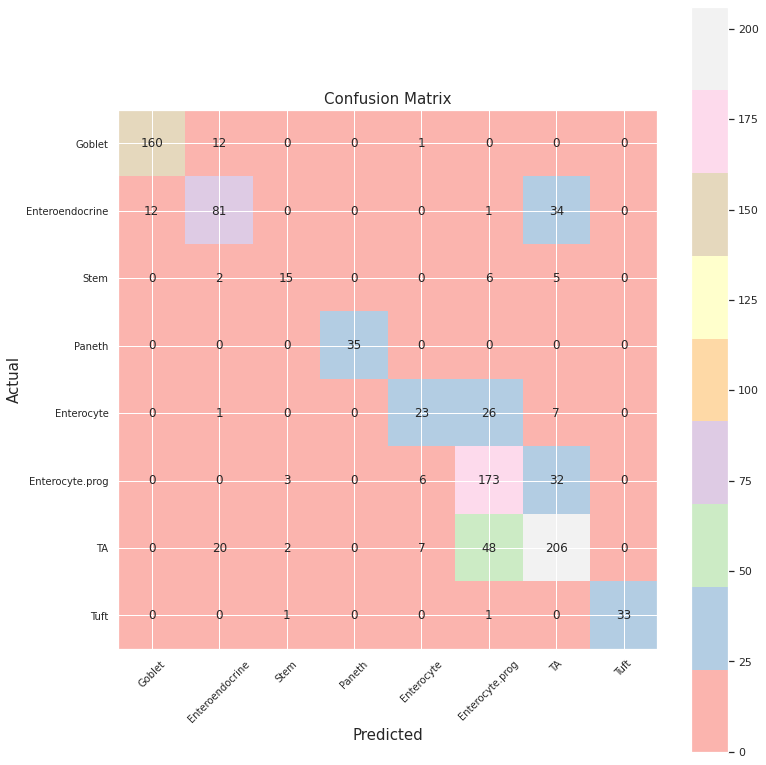

In [26]:
confusion_matrix_Stem(test_lbl_PCA, lgr_best_model_pred)

##KNN

In [27]:
len(train_PCA)

2223

In [33]:
hypr_params = {'n_neighbors': [100, 500, 750, 900]}
KNN = KNeighborsClassifier()
GridSearch_KNN = GridSearchCV(KNN, hypr_params, cv=5)

pca_n_components = [2, 3, 4]
for i in range(len(pca_n_components)):
  pca = PCA(n_components=pca_n_components[i])
  pca.fit(Stem_GE)
  pca.transform(Stem_GE)
  train_x_PCA, test_x_PCA, train_y_PCA, test_y_PCA = train_test_split(Stem_GE, Stem_labels_df, test_size = 0.3, random_state = 1)
  GridSearch_KNN.fit(train_x_PCA, train_y_PCA)
  best_model = GridSearch_KNN.best_estimator_
  print("i: " + str(i) + "\nbest model: " + str(best_model) + "\n score of best model: " + str(best_model.score(test_x_PCA, test_y_PCA)))

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when

i: 0
best model: KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=100, p=2,
                     weights='uniform')
 score of best model: 0.6232948583420777


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when

i: 1
best model: KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=100, p=2,
                     weights='uniform')
 score of best model: 0.6232948583420777


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when

i: 2
best model: KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=100, p=2,
                     weights='uniform')
 score of best model: 0.6232948583420777


In [18]:
pca = PCA(n_components=100)
pca.fit(Stem_GE)
pca.transform(Stem_GE)
train_x_PCA, test_x_PCA, train_y_PCA, test_y_PCA = train_test_split(Stem_GE, Stem_labels_df, test_size = 0.3, random_state = 1)
GridSearch_KNN.fit(train_x_PCA, train_y_PCA)
best_model = GridSearch_KNN.best_estimator_
print("\nbest model: " + str(best_model) + "\n score of best model: " + str(best_model.score(test_x_PCA, test_y_PCA)))

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when


best model: KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=100, p=2,
                     weights='uniform')
 score of best model: 0.6232948583420777


Because the accuracies did not change even with this drastic increase in PCs, we can still use the variable `best_model` from the previous cell as the best model.



In [22]:
best_model.score(test_x_PCA, test_y_PCA)

0.6232948583420777

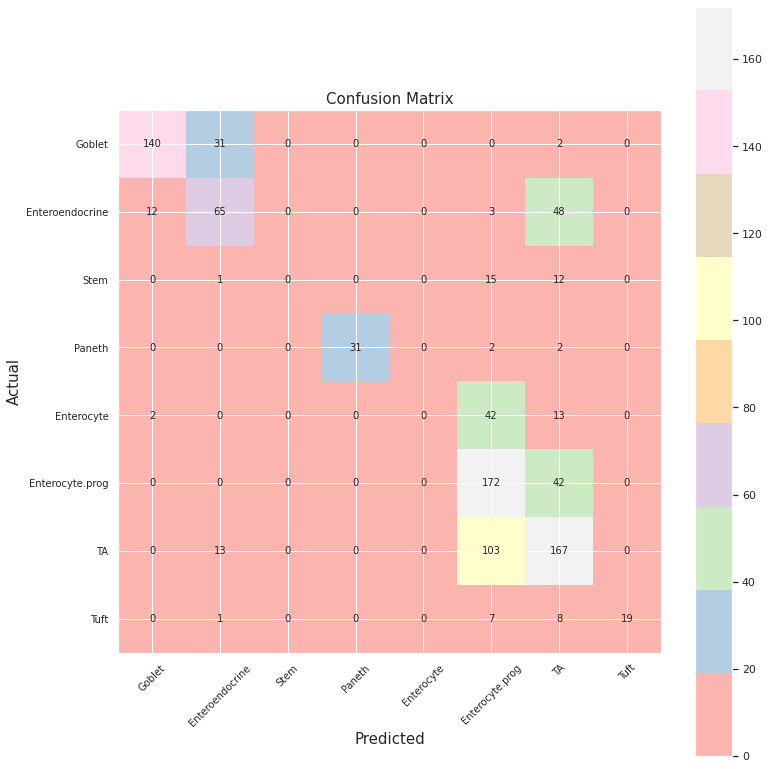

In [21]:
KNN_best_model_pred = best_model.predict(test_x_PCA)
confusion_matrix_Stem(test_y_PCA, KNN_best_model_pred)

##Gausain Naive Bayes

In [33]:
GNB_params_v_smoothing = {"var_smoothing": np.logspace(-64, -25, num=40)}
GNB = GaussianNB()
GNB_grid_search = GridSearchCV(GNB, GNB_params_v_smoothing, cv = 5)

In [34]:
GNB_grid_search.fit(train_PCA, train_lbl_PCA)
GNB_grid_search.best_params_

/usr/local/lib/python3.6/dist-packages/sklearn/naive_bayes.py:206: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/naive_bayes.py:206: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/naive_bayes.py:206: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/naive_bayes.py:206: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = col

{'var_smoothing': 1e-64}

In [35]:
best_GNB_model = GNB_grid_search.best_estimator_
best_GNB_model_pred = best_GNB_model.predict(test_PCA)
best_GNB_model.score(test_PCA, test_lbl_PCA)

0.19412381951731375

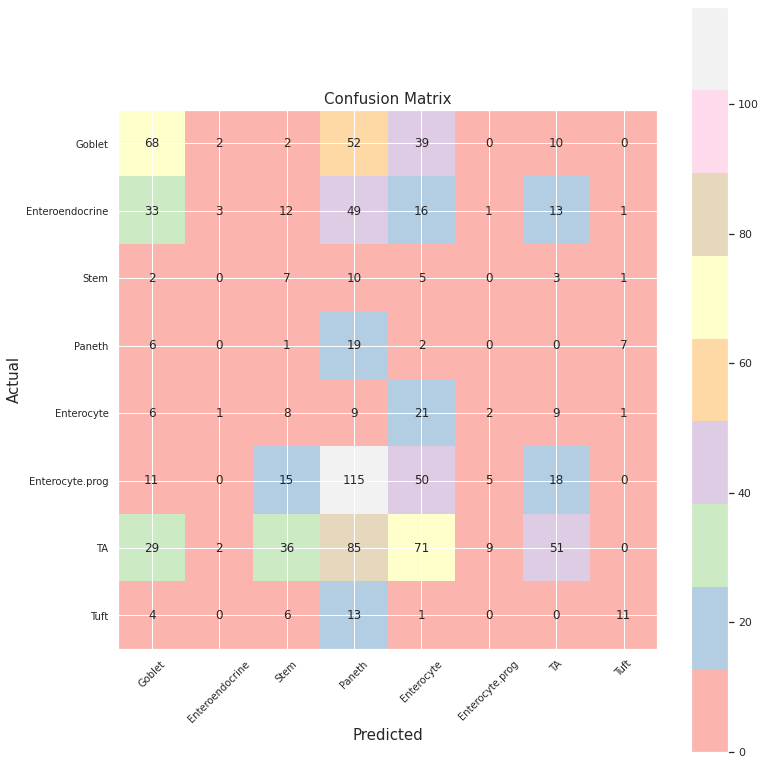

In [36]:
confusion_matrix_Stem(test_lbl_PCA, best_GNB_model_pred)

Let's try using stnadard scaler to see if the data changes

In [17]:
Stem_GE_scaled_PCA_ID = "1yUqDDIrcPpFKyp0Ya5ftM-PlJ6W1y-xg"
Stem_GE_scaled_PCA_file = drive.CreateFile({'id':Stem_GE_scaled_PCA_ID})
Stem_GE_scaled_PCA_file.GetContentFile('Stem_GE_scaled_PCA.csv')
Stem_GE_scaled_PCA = pd.read_csv('Stem_GE_scaled_PCA.csv')

In [20]:
Stem_GE_scaled_PCA = Stem_GE_scaled_PCA.drop("Unnamed: 0", axis=1)

In [26]:
train_PCA_scaled, test_PCA_scaled, train_lbl_PCA_scaled, test_lbl_PCA_scaled = train_test_split(Stem_GE_scaled_PCA, Stem_labels_df, test_size = 0.3, random_state = 1)

In [21]:
GNB_params_v_smoothing_scaled = {"var_smoothing": np.logspace(-64, -25, num=40)}
GNB_scaled = GaussianNB()
GNB_scaled_grid_search = GridSearchCV(GNB_scaled, GNB_params_v_smoothing_scaled, cv = 5)

In [27]:
GNB_scaled_grid_search.fit(train_PCA_scaled, train_lbl_PCA_scaled)
GNB_scaled_grid_search.best_params_

/usr/local/lib/python3.6/dist-packages/sklearn/naive_bayes.py:206: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/naive_bayes.py:206: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/naive_bayes.py:206: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/naive_bayes.py:206: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = col

{'var_smoothing': 1e-64}

In [29]:
best_GNB_model_scaled = GNB_scaled_grid_search.best_estimator_
best_GNB_model_scaled_pred = best_GNB_model_scaled.predict(test_PCA_scaled)
best_GNB_model_scaled.score(test_PCA_scaled, test_lbl_PCA_scaled)

0.3588667366211962

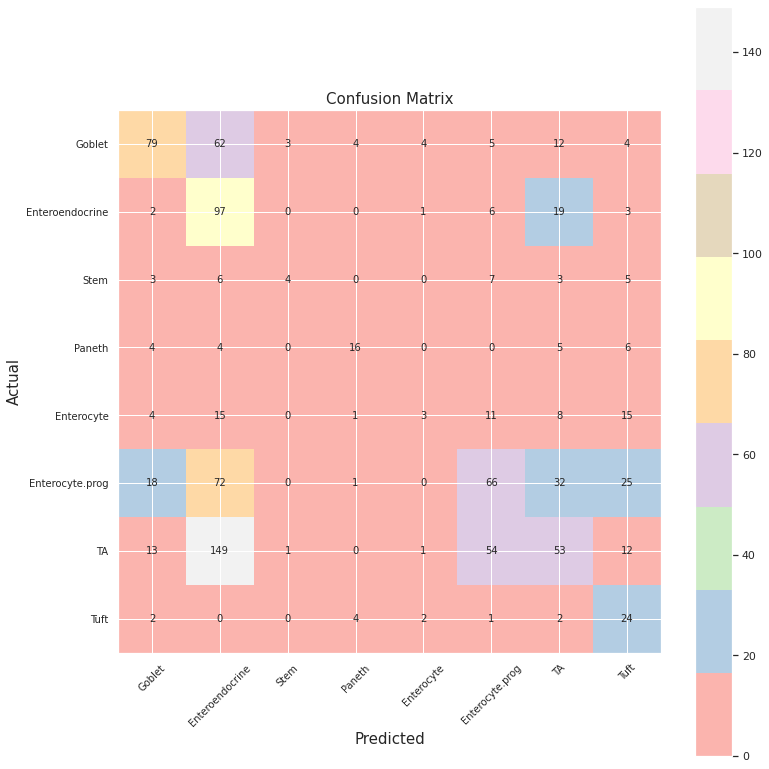

In [32]:
confusion_matrix_Stem(test_lbl_PCA_scaled, best_GNB_model_scaled_pred)

Standard sclaing definitely helped, but not enough to make the model a good one

##Random Forest

In [37]:
RFC_params = {"n_estimators": [10, 100, 500, 1000],
                "max_features": ['sqrt', 'log2', None]}
RFC = RandomForestClassifier(n_jobs=-1, oob_score=True)
RFC_grid_search = GridSearchCV(RFC, RFC_params, cv = 5)
RFC_grid_search.fit(train_PCA, train_lbl_PCA)

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/_forest.py:523: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/_forest.py:528: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr

GridSearchCV(cv=5, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=-1,
                                              oob_score=True, random_state=None,
                                   

In [38]:
RFC_grid_search.best_params_

{'max_features': None, 'n_estimators': 100}

In [39]:
best_RFC_model = RFC_grid_search.best_estimator_
best_RFC_model_pred = best_RFC_model.predict(test_PCA)
best_RFC_model.score(test_PCA, test_lbl_PCA)

0.7292759706190975

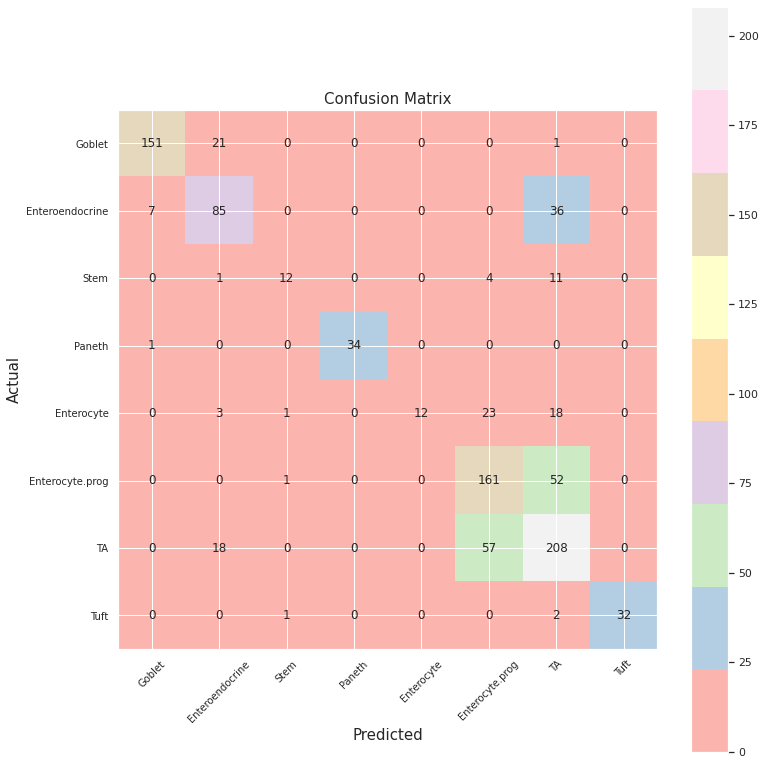

In [40]:
confusion_matrix_Stem(test_lbl_PCA, best_RFC_model_pred)

##Support Vector Machines

In [41]:
SVM_pipe = Pipeline([("model", svm.SVC())])
SVM_params = [{"model": [svm.SVC()],
           "model__kernel": ['linear', 'poly', 'rbf', 'sigmoid'],
           "model__C": np.logspace(-5, 5, num=10),
           "model__gamma": ['auto', 'scale']},
          {"model": [svm.SVC()],
            "model__kernel": ['poly'],
            "model__degree": np.delete(np.logspace(0, 1.3, num=6, dtype=int), 1),
            "model__C": np.logspace(-5, 5, num=10),
            "model__gamma": ['auto', 'scale']}]

SVM_grid_search = GridSearchCV(SVM_pipe, SVM_params, cv=5,n_jobs=-1, verbose=1)
SVM = SVM_grid_search.fit(train_PCA, train_lbl_PCA)

Fitting 5 folds for each of 180 candidates, totalling 900 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  7.9min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed: 17.0min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed: 33.9min
[Parallel(n_jobs=-1)]: Done 900 out of 900 | elapsed: 39.5min finished
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [42]:
SVM_best_model = SVM.best_estimator_
SVM_best_model

Pipeline(memory=None,
         steps=[('model',
                 SVC(C=3.593813663804626, break_ties=False, cache_size=200,
                     class_weight=None, coef0=0.0,
                     decision_function_shape='ovr', degree=1, gamma='scale',
                     kernel='poly', max_iter=-1, probability=False,
                     random_state=None, shrinking=True, tol=0.001,
                     verbose=False))],
         verbose=False)

In [43]:
SVM_best_model_pred = SVM_best_model.predict(test_PCA)
SVM_best_model.score(test_PCA, test_lbl_PCA)

0.782791185729276

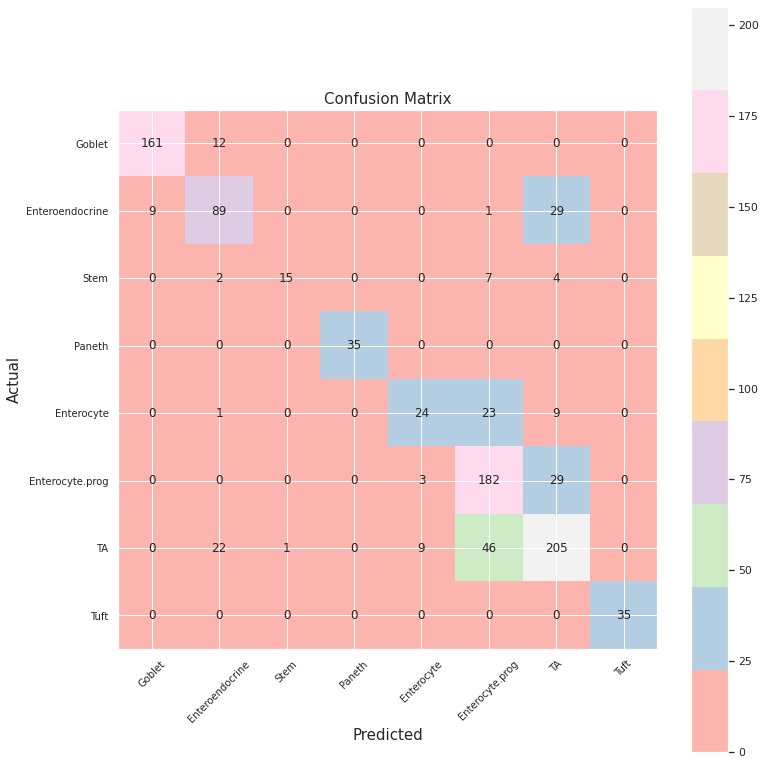

In [44]:
confusion_matrix_Stem(test_lbl_PCA, SVM_best_model_pred)